In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import pickle, os

In [2]:
def plot_roc_curve(y, prob):
    fpr, tpr, _ = roc_curve(y, prob)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
    display.plot()

In [3]:
train = pd.read_csv('data/train_8_12.csv', index_col=[0])
X_train = train.drop(["win", "matchId"], axis=1)
y_train = train['win'].astype(int)

test = pd.read_csv('data/test_8_12.csv', index_col=[0])
X_test = test.drop(["win", "matchId"], axis=1)
y_test = test['win'].astype(int)

## Random Forest Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
RETRAIN = False
rf_file = "models/rf_cv.pkl"

if os.path.exists(rf_file) and not RETRAIN:
    with open(rf_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")
else:
    rf = RandomForestClassifier(random_state=42)
    param_grid = {"n_estimators": (10 ** np.linspace(0, 2.7, 100)).astype(int),
                "max_depth": [6, 8, 10]}
    grid = GridSearchCV(rf, param_grid, scoring="accuracy", n_jobs=-1, verbose=3, cv=10)
    grid.fit(X_train, y_train)

    with open(rf_file, "wb") as f:
        pickle.dump(grid, f)

Succesfully loaded cached gridCV result.


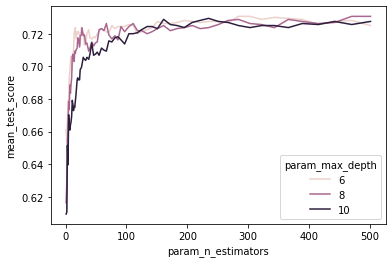

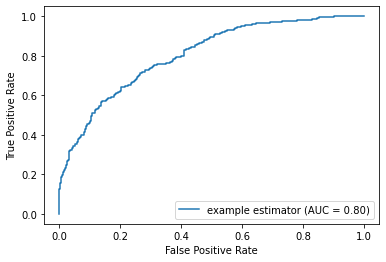

In [6]:
rf_cv_result = pd.DataFrame(grid.cv_results_)
final_rf = grid.best_estimator_

sns.lineplot(x="param_n_estimators", y="mean_test_score", hue="param_max_depth", data=rf_cv_result)
plot_roc_curve(y_test, final_rf.predict_proba(X_test)[:,1])

In [7]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 284}

## XGBoost Classifier

In [4]:
from xgboost import XGBClassifier

In [6]:
RETRAIN = True
xgb_file = "models/xgb_cv.pkl"

if os.path.exists(xgb_file) and not RETRAIN:
    with open(xgb_file, "rb") as f:
        grid = pickle.load(f)
    print("Succesfully loaded cached gridCV result.")

else:
    xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0, silent=True, random_state=42)
    param_grid = {"n_estimator": (10**np.linspace(1, 2.7, 15)).astype(int),
                  "subsample": [0.2, 0.4, 0.6, 0.8],
                  "colsample_bytree": [0.2, 0.4, 0.6, 0.8],
                  "colsample_bylevel": [0.2, 0.4, 0.6, 0.8],
                  "min_child_weight" : [1, 5, 10],
                  "max_depth": [2, 5, 10, 15, 20],}
    grid = GridSearchCV(xgb, param_grid, scoring="accuracy", verbose=3, cv=5, n_jobs=5)
    grid.fit(X_train, y_train)

    with open(xgb_file, "wb") as f:
            pickle.dump(grid, f)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
[CV 2/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.2;, score=0.708 total time=   0.4s
[CV 4/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.2;, score=0.673 total time=   0.4s
[CV 1/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.2;, score=0.671 total time=   0.4s
[CV 3/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.2;, score=0.699 total time=   0.4s
[CV 5/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.2;, score=0.682 total time=   0.4s
[CV 1/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.4;, score=0.693 total time=   0.4s
[CV 4/5] END colsample_bylevel=0.2, colsample_bytree=0.2, max_depth=2, min_child_weight=1, subsample=0.4;, 

In [9]:
xgb_cv_result = pd.DataFrame(grid.cv_results_)
final_xgb = grid.best_estimator_
xgb_cv_result.sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1122,1.358228,0.122297,0.013699,0.002516,0.8,0.6,2,1,0.6,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.711599,0.708464,0.717868,0.764151,0.732704,0.726957,0.020381,1
326,0.576515,0.012208,0.014305,0.001701,0.4,0.2,2,5,0.6,"{'colsample_bylevel': 0.4, 'colsample_bytree':...",0.721003,0.733542,0.721003,0.732704,0.716981,0.725047,0.006761,2
595,2.659110,0.070679,0.018801,0.005095,0.4,0.8,10,1,0.8,"{'colsample_bylevel': 0.4, 'colsample_bytree':...",0.721003,0.730408,0.727273,0.726415,0.716981,0.724416,0.004795,3
247,0.699214,0.005877,0.016616,0.004008,0.2,0.8,2,5,0.8,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.708464,0.752351,0.736677,0.710692,0.713836,0.724404,0.017236,4
811,1.061610,0.014550,0.018536,0.007376,0.6,0.6,2,10,0.8,"{'colsample_bylevel': 0.6, 'colsample_bytree':...",0.714734,0.749216,0.717868,0.729560,0.707547,0.723785,0.014565,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.390116,0.013016,0.019790,0.010524,0.2,0.4,10,100,0.4,"{'colsample_bylevel': 0.2, 'colsample_bytree':...",0.510972,0.507837,0.507837,0.509434,0.490566,0.505329,0.007473,1201
429,0.394676,0.030394,0.022055,0.013947,0.4,0.4,5,100,0.4,"{'colsample_bylevel': 0.4, 'colsample_bytree':...",0.510972,0.507837,0.507837,0.509434,0.490566,0.505329,0.007473,1201
973,0.447284,0.080471,0.021057,0.009448,0.8,0.2,2,100,0.4,"{'colsample_bylevel': 0.8, 'colsample_bytree':...",0.510972,0.507837,0.507837,0.509434,0.490566,0.505329,0.007473,1201
733,0.475276,0.054085,0.016832,0.004352,0.6,0.4,2,100,0.4,"{'colsample_bylevel': 0.6, 'colsample_bytree':...",0.510972,0.507837,0.507837,0.509434,0.490566,0.505329,0.007473,1201


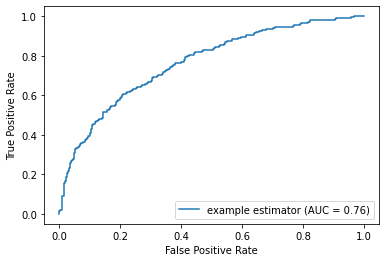

In [10]:
plot_roc_curve(y_test, final_xgb.predict_proba(X_test)[:,1])

## HyperOpt

In [11]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [12]:
def objectives(params):
    classifier_type = params['type']
    del params['type']
    if classifier_type == 'rf':
        clf = RandomForestClassifier(**params, random_state=42)
    elif classifier_type == 'xgb':
        clf = XGBClassifier(**params, eval_metric="logloss", use_label_encoder=False, random_state=42)
    accuracy = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1).mean()
    return {'loss': -accuracy, 'status': hyperopt.STATUS_OK}

space = hp.choice('clf_type', [
    {
        "type": "rf",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    },
    {
        "type": "xgb",
        "n_estimators": sample(scope.int(hp.quniform("n_estimators", 0, 800, 1))),
        "max_depth": sample(scope.int(hp.quniform("max_depth", 5, 15, 1)))
    }
])

trials = hyperopt.Trials()

best = hyperopt.fmin(objectives, 
                     space, 
                     algo=hyperopt.tpe.suggest, 
                     max_evals=50,
                     trials=trials)

100%|██████████| 50/50 [07:52<00:00,  9.45s/trial, best loss: -0.7187890617298555]


In [13]:
hyperopt.space_eval(space, best)

{'max_depth': 6, 'n_estimators': 437, 'type': 'rf'}